In [42]:
# Mass estimate of Kepler-10c using RadVel package (https://github.com/California-Planet-Search/radvel.git)

%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.likelihood
from radvel.plot import orbit_plots, mcmc_plots

matplotlib.rcParams['font.size'] = 14

In [43]:
# Loading data for Kepler 10-c from Weiss et.al 2016
data = np.genfromtxt('apj522668t1_ascii.txt', delimiter = '\t', dtype = 'str', skip_header=6, skip_footer = 1) 

Unfortunately, Weiss reported her radial velocity uncertainty with jitter added in. It is certainly possible to obtain the intrinsic RV uncertainty by subtracting the reported telescope-specific jitter value (table 3 in Weiss 2016) in quadrature from the reported total error using the following equation (Equation 1 in Weiss 2016):

$$
\mathcal{L}=\prod_{i} \frac{1}{\sqrt{2 \pi\left(\sigma_{i}^{2}+\sigma_{j}^{2}\right)}} \exp \left[-\frac{\left(\mathrm{RV}_{i}-\mathrm{RV}_{mod, i}\right)^{2}}{2\left(\sigma_{i}^{2}+\sigma_{j}^{2}\right)}\right]
$$

While it likely won't effect our results to use this method, it is best practice to download and read in the fits files from HIRES and HARPS-N instead.

In [59]:
t = data[:,0]
t = np.array([float(i) for i in t])
t 

array([ 173.900499,  174.877797,  175.773348,  176.862854,  177.923401,
        178.922398,  179.972876,  180.896063,  181.969271,  182.847887,
        183.760854,  183.945387,  184.877994,  206.889914,  208.885123,
        208.890922,  211.830107,  269.71177 ,  269.720925,  269.733899,
        270.715114,  270.733655,  272.756489,  273.714025,  273.720425,
        273.727555,  412.04715 ,  413.004124,  414.004814,  415.111272,
        417.998478,  418.121283,  419.027179,  420.062974,  421.006521,
        421.969467,  443.050045,  444.031958,  444.964655,  444.977237,
        445.068315,  450.972744,  451.987745,  473.81361 ,  476.86488 ,
        479.902118,  503.897962,  505.056086,  507.012774,  511.985723,
        512.805268,  514.80255 , 1172.682384, 1172.704768, 1187.57572 ,
       1187.596901, 1203.106739, 1203.661644, 1203.689793, 1215.691945,
       1215.713149, 1216.704755, 1216.719003, 1225.568254, 1225.589446,
       1226.447899, 1226.664948, 1227.422428, 1227.441641, 1228.

In [60]:
rv = data[:,1]
rv = np.array([float(i) for i in rv])
rv

array([  5.21,   0.37,   3.31,   1.1 ,  -6.28,   5.96,   0.9 ,   2.56,
        -9.41,  -8.01,  -1.3 ,  -3.17,  -1.17,   0.64,  -8.82,  -6.76,
        10.61,  -0.59,  -0.77,   5.59,  -0.47,  -6.97,   3.48,   1.35,
         4.13,  -0.49,  -3.91,  -2.11,  -9.03,  -0.13,   2.79,  -2.3 ,
        -0.98,   2.83,   2.53,   1.75,  -1.13,  -1.08,  -3.66,  -8.96,
        -3.82,  -0.41,  -0.93,   3.54,  -1.89,  -0.74,   2.84,  -4.34,
        -1.3 ,  -4.08,  -4.57,  -4.5 ,  -2.7 ,  -3.04,  -1.67,   4.37,
        -5.79,  -0.55,  -4.47,  -3.45,  -7.55,   2.06,  -2.56,  -7.06,
        -8.06,  -2.83,  -0.54, -13.21,   0.41,   2.16,  -2.77,  -1.7 ,
         7.45,  10.45,   3.48,  -0.48,   1.01,   0.59,   2.11,  -5.91,
         4.45,  -1.01,  -3.28,  -4.78,  -5.06,  -8.23,  -6.97,  -9.35,
         1.87,   3.11,   3.74,  -4.07,  -4.84,   0.67,   4.18,   3.13,
        -5.11,   5.83,   3.53,   4.21,   5.13,   2.94,  -0.84, -16.52,
         3.71,   1.78,  -1.19,   0.  ,   4.16,  -8.77,  -0.79,   0.46,
      

In [46]:
rv_error = data[:,2]
rv_error = np.array([float(i) for i in rv_error])
rv_error

array([ 4.18,  3.94,  3.95,  3.96,  3.97,  3.96,  4.  ,  3.94,  3.96,
        3.97,  3.92,  3.99,  3.93,  4.04,  4.28,  5.28,  4.38,  4.22,
        4.08,  4.04,  3.99,  3.98,  4.03,  3.97,  5.03,  4.  ,  3.94,
        3.94,  3.95,  4.12,  3.96,  3.93,  4.06,  3.95,  3.93,  3.97,
        3.9 ,  3.93,  4.34,  3.93,  4.  ,  3.92,  3.95,  3.97,  3.88,
        3.98,  3.89,  4.06,  3.92,  3.86,  3.86,  3.93,  3.05,  3.11,
        3.32,  3.18,  3.9 ,  3.45,  3.32,  3.04,  3.22,  4.47,  4.77,
        3.76,  3.31,  2.94,  4.53,  9.66,  2.91,  2.95,  2.94,  3.14,
        3.22,  3.06,  3.05,  3.33,  2.84,  3.36,  2.98,  4.83,  2.97,
        4.25,  3.98,  3.42,  3.65,  3.33,  3.28,  3.47,  3.27,  3.27,
        3.45,  3.36,  3.48,  3.91,  2.84,  2.97,  3.09,  3.03,  2.91,
        3.02,  2.84,  2.97,  2.81,  9.34,  2.98,  2.86,  2.98,  3.23,
        3.08,  2.93,  2.98,  3.32,  3.25,  3.18,  3.06,  2.94,  2.94,
        2.88,  3.  ,  2.86,  2.84,  3.41,  3.09, 11.61,  5.82,  7.95,
        3.27,  3.19,

In [47]:
inst = data[:,4]
inst = np.array(inst)
inst

array(['HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HIRES', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'H

In [48]:
x = radvel.utils.bintels(t,rv,rv_error,inst,binsize = 0.000001) #bins by telescope. can also use list comp. 
hires_t = x[0][:72]
hires_rv = x[1][:72]
hires_rv_error = x[2][:72]
hires_rv_error = np.sqrt(hires_rv_error**2 - 3.62**2) #removing jitter
hires_inst = x[3][:72]


harps_one_t = x[0][72:127]
harps_one_rv = x[1][72:127]
harps_one_rv_error = x[2][72:127]
harps_one_rv_error = np.sqrt(harps_one_rv_error**2 - 2.49**2)
harps_one_inst = x[3][72:127]

harps_two_t = x[0][127:]
harps_two_rv = x[1][127:]
harps_two_rv_error = x[2][127:]
harps_two_rv_error = np.sqrt(harps_two_rv_error**2 - 2.49**2)
harps_two_inst = x[3][127:]

gamma_hires = np.median(x[1][:72]) # median of binned radial velocity data for HIRES observation
gamma_harps_one = np.median(x[1][72:127])
gamma_harps_two = np.median(x[1][127:])



In [49]:
hires = [hires_t,hires_rv,hires_rv_error,hires_inst] #hires data
harps_one = [harps_one_t,harps_one_rv,harps_one_rv_error,harps_one_inst]
harps_two = [harps_two_t,harps_two_rv,harps_two_rv_error,harps_two_inst]
hires
starname = 'Kepler 10'
instnames = ['HIRES', 'HARPS1', 'HARPS2']
nplanets = 2    # number of planets in the system
planet_letters = {1: 'b', 2: 'c'}   # map the numbers in the Parameters keys to planet letters (for plotting and tables)

In [50]:
def initialize_model():
    time_base = 0 #BJD: barycentric julian date: center of mass from solar system (barycentric correction b/c different sides of solar system from earth)
    params = radvel.Parameters(nplanets,basis='per tc secosw sesinw logk')
    params['per1'] = radvel.Parameter(value=0.837491331) # period [days]
    params['tc1'] = radvel.Parameter(value=2454964.57475-2454900) # time of transit
    params['secosw1'] = radvel.Parameter(value=0) #sqrt(e)*cos(omega)
    params['sesinw1'] = radvel.Parameter(value=0) #sqrt(e)*sin(omega)
    params['logk1'] = radvel.Parameter(value=0.518514) # log(semi-amplitude)
    params['per2'] = radvel.Parameter(value=45.29431717)
    params['tc2'] = radvel.Parameter(value= 2454971.67748-2454900)
    params['secosw2'] = radvel.Parameter(value=0)
    params['sesinw2'] = radvel.Parameter(value=0)
    params['logk2'] = radvel.Parameter(value=0.149219113)
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=0) # short term linear shift for binary system
    mod.params['curv'] = radvel.Parameter(value=0) # long term quadratic shift for binary system
    return mod

# By reparameterizing eccentricity/argument of periastron in this way, we create a circle where the distance from the 
# center of the circle corresponds to the eccentricity (i.e points on the edge correspond to e=1, points in the middle 
# correspond to e=0). This helps mitigate against an artificial build up of eccentricities near zero (it would otherwise be 
# difficult to tell if e=0 build up is due to a boundary condition at e=0 or not).

# Exploring semi-amplitude in log-space -> explore lower values more often 

# Transit time selection is a bit more nuanced than it initially appears. If data for transit time occurs well-
# before or well-after rv data then we have to worry about aliasing (see stale ephemerides). 
# Not a problem for Kepler-10 data


In [51]:
def initialize_likelihood(t,rv,rv_error,suffix):
    like = radvel.likelihood.RVLikelihood(
        mod, t, rv, rv_error, suffix=suffix)
    return like
mod = initialize_model()

# Build up HIRES likelihood
like_hires = initialize_likelihood(hires_t,hires_rv,hires_rv_error,'_hires')
like_hires.params['gamma_hires'] = radvel.Parameter(gamma_hires)
like_hires.params['jit_hires'] = radvel.Parameter(value=3.62)

# Build up HARPS-1 likelihood
like_harps_one = initialize_likelihood(harps_one_t,harps_one_rv,harps_one_rv_error,'_harps_one')
like_harps_one.params['gamma_harps_one'] = radvel.Parameter(gamma_harps_one)
like_harps_one.params['jit_harps_one'] = radvel.Parameter(value=2.49)

# Build up HARPS-2 likelihood
like_harps_two = initialize_likelihood(harps_two_t,harps_two_rv,harps_two_rv_error,'_harps_two')
like_harps_two.params['gamma_harps_two'] = radvel.Parameter(gamma_harps_one)
like_harps_two.params['jit_harps_two'] = radvel.Parameter(value=2.49)

# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood([like_hires,like_harps_one,like_harps_two])

like.params['secosw1'].vary = True
like.params['sesinw1'].vary = True
like.params['secosw2'].vary = True
like.params['sesinw2'].vary = True
like.params['per1'].vary = True
like.params['per2'].vary = True
like.params['tc1'].vary = True
like.params['tc2'].vary = True
like.params['dvdt'].vary= False
like.params['curv'].vary= False
print(like)

parameter                     value      vary
per1                       0.837491       True
tc1                         64.5748       True
secosw1                           0       True
sesinw1                           0       True
logk1                      0.518514       True
per2                        45.2943       True
tc2                         71.6775       True
secosw2                           0       True
sesinw2                           0       True
logk2                      0.149219       True
dvdt                              0      False
curv                              0      False
gamma_hires                  -0.375       True
jit_hires                      3.62       True
gamma_harps_one               -0.55       True
jit_harps_one                  2.49       True
gamma_harps_two               -0.55       True
jit_harps_two                  2.49       True
tp1                         64.3654           
e1                                0           
w1            

In [52]:
import copy

# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
# Uniform priors for everything but period/transit time

# Period and Transit time from transit modelling in Morton et al. 2016. While, Gajdoš et al. 2019 provided slightly
# better constraints for period/transit time, period/transit time are very well constrained across all papers,
# so we place an outsized importance on the estimate of planet radius which will be used to calculate planet density. 
# An estimate for planet radius was not reported in Gajdoš 2019. 

post.priors += [radvel.prior.EccentricityPrior( 2 )] # Keeps eccentricity < 1
post.priors += [radvel.prior.HardBounds( 'logk2', -1, 4)]
post.priors += [radvel.prior.HardBounds( 'logk1', -1, 4)]
post.priors += [radvel.prior.Gaussian('per2',45.29431717, 0.00005283)]
post.priors += [radvel.prior.Gaussian('tc2',2454971.67748-2454900,0.00089)]
post.priors += [radvel.prior.Gaussian('per1',0.837491331,0.000000272)]
post.priors += [radvel.prior.Gaussian('tc1',2454964.57475-2454900,0.000261)]
post.priors += [radvel.prior.HardBounds( 'gamma_hires', gamma_hires - 3*np.std(x[1][:72]), gamma_hires + 3*np.std(x[1][:72]))]
post.priors += [radvel.prior.HardBounds( 'gamma_harps_one', gamma_harps_one - 3*np.std(x[1][72:127]),gamma_harps_one+ 3*np.std(x[1][72:127]))]
post.priors += [radvel.prior.HardBounds( 'gamma_harps_two', gamma_harps_two - 3*np.std(x[1][127:]),gamma_harps_two + 3*np.std(x[1][127:]))]
post.priors += [radvel.prior.HardBounds( 'jit_hires', 0, 10)] 
post.priors += [radvel.prior.HardBounds( 'jit_harps_one', 0, 10)] 
post.priors += [radvel.prior.HardBounds( 'jit_harps_two', 0, 10)]  

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(),
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )

print("Initial loglikelihood = %f" % post0.logprob())
print("Final loglikelihood = %f" % post.logprob())
print(post)

Initial loglikelihood = -599.792532
Final loglikelihood = -563.365027
parameter                     value      vary
per1                       0.837491       True
tc1                         64.5748       True
secosw1                   -0.255831       True
sesinw1                -0.000181879       True
logk1                       1.00833       True
per2                        45.2943       True
tc2                         71.6775       True
secosw2                    0.145957       True
sesinw2                     0.42167       True
logk2                         1.085       True
dvdt                              0      False
curv                              0      False
gamma_hires            -0.000311472       True
jit_hires                   3.46165       True
gamma_harps_one            0.148093       True
jit_harps_one               2.32197       True
gamma_harps_two          -0.0169302       True
jit_harps_two               2.44213       True
tp1                         64.7668   

In [53]:
df = radvel.mcmc(post,nwalkers=40,nrun=15000, savename='rawchains.h5', minTz=False)
# G-R: Gelman Rubin Metric: how much variation within a given chain versus how much variation between all of the chains
# < 1.01


240000/4800000 (5.0%) steps complete; Running 1346.92 steps/s; Mean acceptance rate = 33.4%; Min Auto Factor =  35; Max Auto Relative-Change =   inf; Min Tz = 2566.3; Max G-R = 1.011
Discarding burn-in now that the chains are marginally well-mixed

688000/4800000 (14.3%) steps complete; Running 1324.46 steps/s; Mean acceptance rate = 31.2%; Min Auto Factor =  49; Max Auto Relative-Change = 0.0234; Min Tz = 7898.0; Max G-R = 1.004
Chains are well-mixed after 688000 steps! MCMC completed in 8.8 minutes




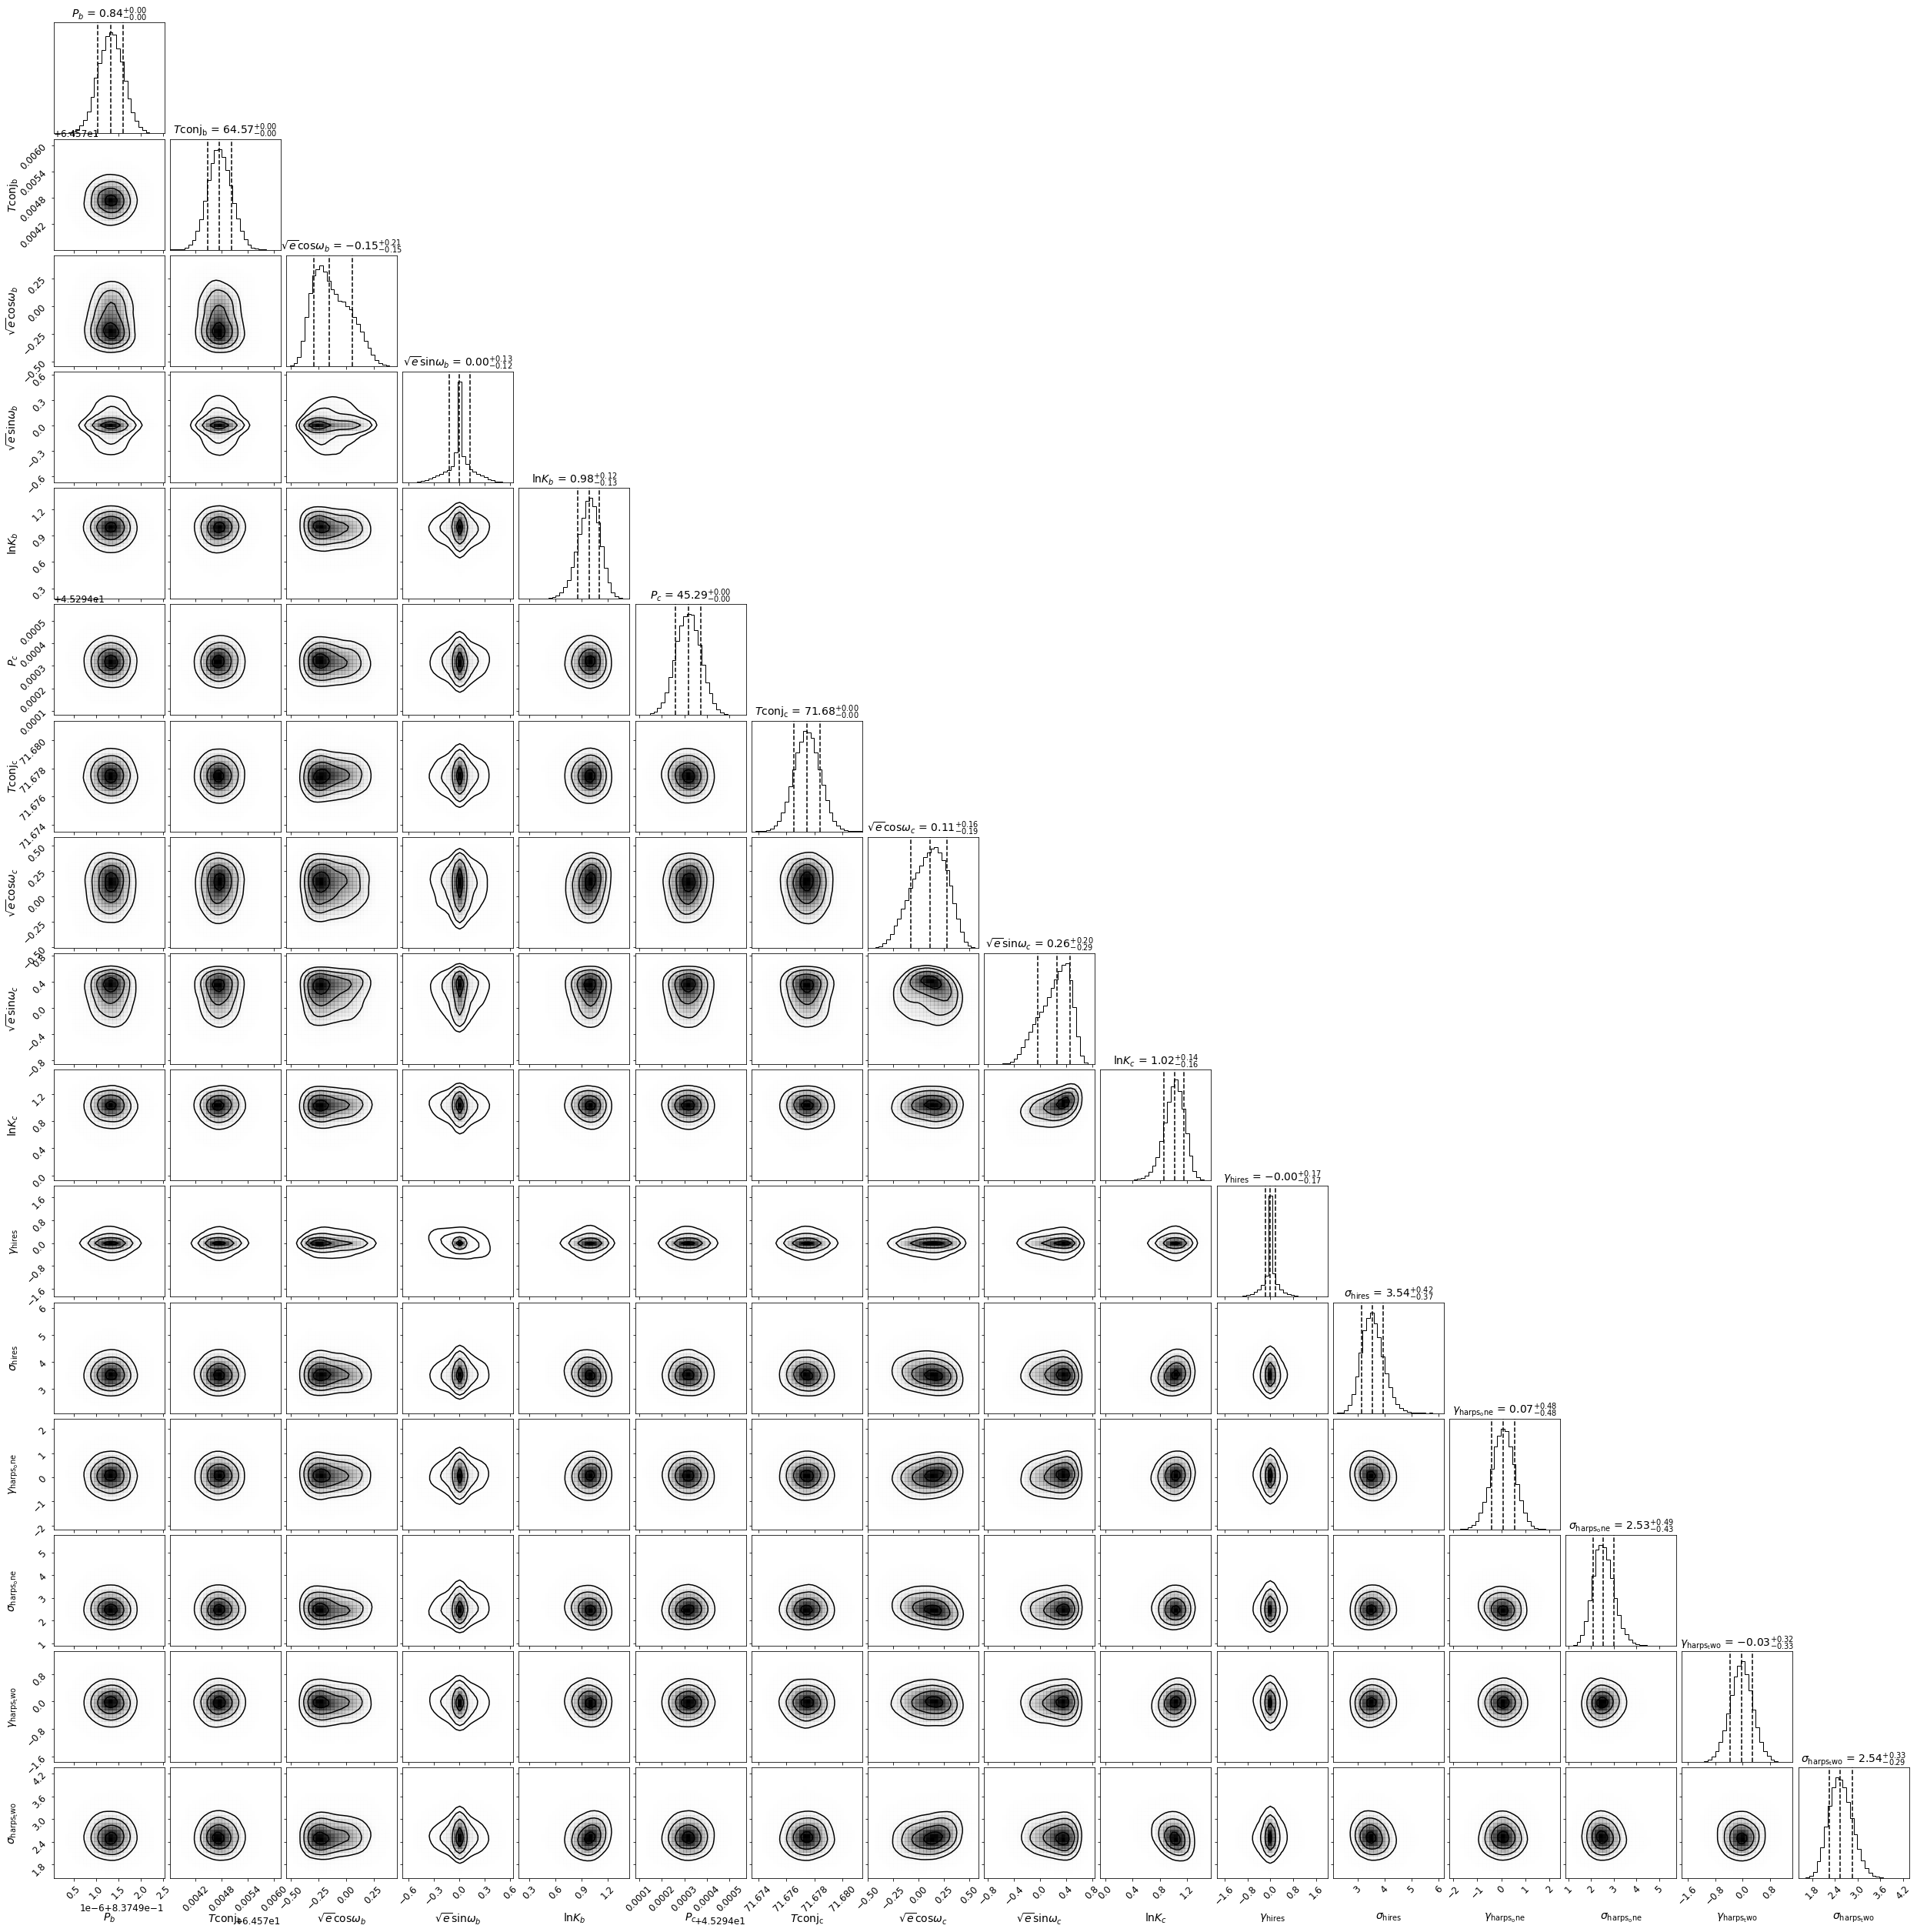

In [54]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()

(<Figure size 540x786.857 with 5 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fb395cbd9a0>])

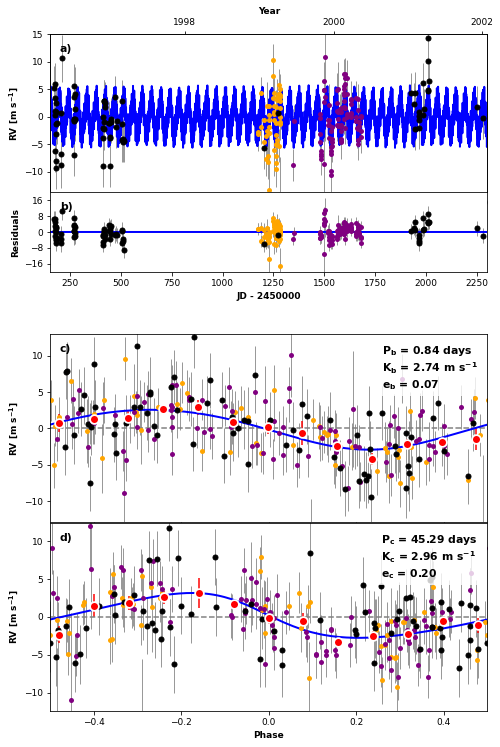

In [55]:
RVPlot = orbit_plots.MultipanelPlot(post, legend=False)
RVPlot.plot_multipanel()

In [56]:
df

,per1,tc1,secosw1,sesinw1,logk1,per2,tc2,secosw2,sesinw2,logk2,gamma_hires,jit_hires,gamma_harps_one,jit_harps_one,gamma_harps_two,jit_harps_two,lnprobability
0,0.837491,64.574412,-0.041827,0.000033,1.205327,45.294307,71.678069,0.397185,0.082933,0.819212,0.009327,3.807039,0.830316,2.218312,-0.190704,3.082530,-572.661079
1,0.837491,64.574412,-0.041827,0.000033,1.205327,45.294307,71.678069,0.397185,0.082933,0.819212,0.009327,3.807039,0.830316,2.218312,-0.190704,3.082530,-572.661079
2,0.837491,64.574412,-0.041827,0.000033,1.205327,45.294307,71.678069,0.397185,0.082933,0.819212,0.009327,3.807039,0.830316,2.218312,-0.190704,3.082530,-572.661079
3,0.837491,64.574412,-0.041827,0.000033,1.205327,45.294307,71.678069,0.397185,0.082933,0.819212,0.009327,3.807039,0.830316,2.218312,-0.190704,3.082530,-572.661079
4,0.837491,64.574412,-0.041827,0.000033,1.205327,45.294307,71.678069,0.397185,0.082933,0.819212,0.009327,3.807039,0.830316,2.218312,-0.190704,3.082530,-572.661079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447995,0.837491,64.574816,-0.090735,0.120264,1.014869,45.294284,71.677687,0.186504,0.320346,1.027450,-0.562258,3.867374,-0.108032,2.879946,0.031403,2.201295,-567.432746
447996,0.837491,64.574816,-0.090735,0.120264,1.014869,45.294284,71.677687,0.186504,0.320346,1.027450,-0.562258,3.867374,-0.108032,2.879946,0.031403,2.201295,-567.432746
447997,0.837491,64.574817,-0.084176,0.120721,1.013136,45.294277,71.677733,0.184164,0.323621,1.022957,-0.567194,3.880243,-0.131106,2.933163,-0.006371,2.168719,-568.014594
447998,0.837491,64.574817,-0.084176,0.120721,1.013136,45.294277,71.677733,0.184164,0.323621,1.022957,-0.567194,3.880243,-0.131106,2.933163,-0.006371,2.168719,-568.014594


In [57]:
k_c = np.array(df.logk2)
k_c = np.power(np.e,k_c)
per_c = np.array(df.per2)
ecc_c = np.array(df.secosw2)**2 + np.array(df.secosw2)**2
ecc_b = np.array(df.secosw1)**2 + np.array(df.secosw1)**2
stellar_mass = 0.920 # (Silva Aguirre et al. 2015)


# It is important to note that we are using different sources for stellar mass (Silva Aguirre 2015) and 
# period/transit time (Morton 2016) without worrying about data cross-contamination. 
# Period and transit time are modelled from Kepler cadence photometry which is typically not used to model 
# stellar parameters. Although asteroseismology technically relies on photometry, asteroseismology fits the p-mode 
# oscillations of a star, not transits. So, we can use the mass estimate of Silva Aguirre (2015) without worry 
# of cross-contamination.

# It is also important to note that we must use the values found in Silva Aguirre (2015) for other stellar parameters. 
# We want our planet radius and mass to be derived from the same set of stellar parameters, so our planet density
# estimate will be reliable. 


In [58]:
mass = radvel.utils.Msini(k_c, per_c, stellar_mass, ecc_c, Msini_units='earth')
print('Mass estimate of Kepler-10c:' , np.median(mass))

Mass estimate of Kepler-10c: 14.490835392745575


In [ ]:
# Next step: implement GP on top of existing code to improve fitting. 